In [1]:
# All Categories
CATEGORY_MAP = {
    "Computer Science": [
        "cs.AI", "cs.CL", "cs.CC", "cs.CE", "cs.CV", "cs.CY", "cs.CR",
        "cs.DS", "cs.DB", "cs.DL", "cs.DM", "cs.DC", "cs.ET", "cs.FL",
        "cs.GL", "cs.GR", "cs.GT", "cs.HC", "cs.IR", "cs.IT", "cs.LG",
        "cs.LO", "cs.MS", "cs.MA", "cs.MM", "cs.NI", "cs.NE", "cs.NA",
        "cs.OS", "cs.OH", "cs.PF", "cs.PL", "cs.RO", "cs.SI", "cs.SE",
        "cs.SD", "cs.SC", "cs.SY"
    ],
    "Economics": [
        "econ.EM", "econ.GN", "econ.TH"
    ],
    "Electrical Engineering and Systems Science": [
        "eess.AS", "eess.IV", "eess.SP", "eess.SY"
    ],
    "Mathematics": [
        "math.AG", "math.AT", "math.AP", "math.CT", "math.CA", "math.CO",
        "math.AC", "math.CV", "math.DG", "math.DS", "math.FA", "math.GM",
        "math.GN", "math.GT", "math.GR", "math.HO", "math.IT", "math.KT",
        "math.LO", "math.MP", "math.MG", "math.NT", "math.NA", "math.OA",
        "math.OC", "math.PR", "math.QA", "math.RT", "math.RA", "math.SP",
        "math.ST", "math.SG"
    ],
    "Physics": [
        "physics.acc-ph", "physics.app-ph", "physics.ao-ph", "physics.atom-ph",
        "physics.atm-clus", "physics.bio-ph", "physics.chem-ph", "physics.class-ph",
        "physics.comp-ph", "physics.data-an", "physics.flu-dyn", "physics.gen-ph",
        "physics.geo-ph", "physics.hist-ph", "physics.ins-det", "physics.med-ph",
        "physics.optics", "physics.ed-ph", "physics.soc-ph", "physics.plasm-ph",
        "physics.pop-ph", "physics.space-ph", "quant-ph", "hep-th", "hep-ph",
        "hep-ex", "hep-lat", "astro-ph", "astro-ph.CO", "astro-ph.HE", "astro-ph.GA",
        "astro-ph.IM", "astro-ph.SR", "astro-ph.EP", "cond-mat", "cond-mat.mtrl-sci",
        "cond-mat.mes-hall", "cond-mat.other", "cond-mat.quant-gas", "cond-mat.soft",
        "cond-mat.stat-mech", "cond-mat.str-el", "cond-mat.supr-con", "nucl-ex",
        "nucl-th"
    ],
    "Quantitative Biology": [
        "q-bio.BM", "q-bio.CB", "q-bio.GN", "q-bio.MN", "q-bio.NC", "q-bio.OT",
        "q-bio.PE", "q-bio.QM", "q-bio.SC", "q-bio.TO"
    ],
    "Quantitative Finance": [
        "q-fin.CP", "q-fin.EC", "q-fin.GN", "q-fin.MF", "q-fin.PM", "q-fin.PR",
        "q-fin.RM", "q-fin.ST", "q-fin.TR"
    ],
    "Statistics": [
        "stat.AP", "stat.CO", "stat.ML", "stat.ME", "stat.OT", "stat.TH"
    ]
}

In [2]:
import json
import random
from collections import defaultdict

# Configuration
TARGETS = {
    "Computer Science": 0.125,
    "Economics": 0.125,
    "Electrical Engineering and Systems Science": 0.125,
    "Mathematics": 0.125,
    "Physics": 0.125,
    "Quantitative Biology": 0.125,
    "Quantitative Finance": 0.125,
    "Statistics": 0.125
}
TOTAL_PAPERS = 300
subset_categorised_data = '/content/drive/MyDrive/GraphRAG/subset_categorised_data.json'
full_data = '/content/drive/MyDrive/GraphRAG/arxiv_data.json'
RANDOM_SEED = 42


def map_to_domain(categories_str):
    """Map arXiv categories to research domains with hierarchical matching"""
    if not categories_str:
        return None

    categories = categories_str.split()

    # Check hierarchical matches (e.g. cs.AI matches cs.AI.ML)
    for domain, keywords in CATEGORY_MAP.items():
        for kw in keywords:
            if any(cat == kw or cat.startswith(kw + '.') for cat in categories):
                return domain
    return None

# Initialize
random.seed(RANDOM_SEED)
buckets = defaultdict(list)
target_counts = {domain: round(proportion * TOTAL_PAPERS) for domain, proportion in TARGETS.items()}
storage_limits = {domain: max(10, int(1.5 * target_counts[domain])) for domain in TARGETS}

# First pass: Categorize papers
with open(full_data, "r", encoding="utf-8") as f:
    for line in f:
        try:
            paper = json.loads(line)
            domain = map_to_domain(paper.get("categories", ""))

            if domain and len(buckets[domain]) < storage_limits[domain]:
                buckets[domain].append(paper)

                # Early exit if all domains have sufficient candidates
                if all(len(buckets[d]) >= target_counts[d] for d in TARGETS):
                    break
        except json.JSONDecodeError:
            continue  # Skip malformed lines

# Second pass: Sample from buckets
sampled = []
for domain in TARGETS:
    target = target_counts[domain]
    available = len(buckets[domain])

    if available < target:
        print(f"Warning: Only {available} {domain} papers found (wanted {target})")
        if available > 0:
            sampled.extend(buckets[domain])
    else:
        sampled.extend(random.sample(buckets[domain], target))

# Shuffle final sample and save
random.shuffle(sampled)
with open(subset_categorised_data, "w", encoding="utf-8") as f:
    for paper in sampled:
        f.write(json.dumps(paper) + "\n")

# Verification report
print(f"\nSuccessfully sampled {len(sampled)} papers with distribution:")
for domain in TARGETS:
    count = sum(1 for p in sampled if map_to_domain(p.get("categories", "")) == domain)
    print(f"- {domain}: {count} papers ({count/len(sampled):.1%})")

# Show sample papers for verification
print("\nSample papers from each domain:")
for domain in TARGETS:
    domain_papers = [p for p in sampled if map_to_domain(p.get("categories", "")) == domain]
    if domain_papers:
        print(f"\n{domain} example:")
        print(f"ID: {domain_papers[0]['id']}")
        print(f"Title: {domain_papers[0]['title']}")
        print(f"Categories: {domain_papers[0]['categories']}")


Successfully sampled 304 papers with distribution:
- Computer Science: 38 papers (12.5%)
- Economics: 38 papers (12.5%)
- Electrical Engineering and Systems Science: 38 papers (12.5%)
- Mathematics: 38 papers (12.5%)
- Physics: 38 papers (12.5%)
- Quantitative Biology: 38 papers (12.5%)
- Quantitative Finance: 38 papers (12.5%)
- Statistics: 38 papers (12.5%)

Sample papers from each domain:

Computer Science example:
ID: 0704.1269
Title: Phase Transitions in the Coloring of Random Graphs
Categories: cond-mat.dis-nn cond-mat.stat-mech cs.CC

Economics example:
ID: 1506.07368
Title: On Game-Theoretic Risk Management (Part One) -- Towards a Theory of
  Games with Payoffs that are Probability-Distributions
Categories: econ.GN math.ST q-fin.EC stat.AP stat.TH

Electrical Engineering and Systems Science example:
ID: 1709.08182
Title: Neuromorphic adaptive edge-preserving denoising filter
Categories: eess.IV

Mathematics example:
ID: 0704.0112
Title: Placeholder Substructures III: A Bit-Str

In [3]:
import json
import re
import csv
import os
import pandas as pd
import networkx as nx
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from collections import defaultdict
import datetime
import community as community_louvain

# Configuration
INPUT_FILE = '/content/drive/MyDrive/GraphRAG/subset_categorised_data.json'
OUTPUT_DIR = 'graph_data'
GRAPH_FILE = 'enriched_graph.graphml'

# Latex escape mapping
LATEX_ESCAPES = {
    r"\\'a": "á", r"\\'e": "é", r"\\'i": "í", r"\\'o": "ó", r"\\'u": "ú",
    r"\\'A": "Á", r"\\'E": "É", r"\\'I": "Í", r"\\'O": "Ó", r"\\'U": "Ú",
    r'\\"a': "ä", r'\\"e': "ë", r'\\"i': "ï", r'\\"o': "ö", r'\\"u': "ü",
    r'\\"A': "Ä", r'\\"E': "Ë", r'\\"I': "Ï", r'\\"O': "Ö", r'\\"U': "Ü",
    r'\\`a': "à", r'\\`e': "è", r'\\`i': "ì", r'\\`o': "ò", r'\\`u': "ù",
}

def clean_text(text):
    """Clean and normalize text fields"""
    if not text:
        return ""
    for esc, char in LATEX_ESCAPES.items():
        text = text.replace(esc, char)
    text = re.sub(r'\s+', ' ', text.replace('\n', ' ')).strip()
    return text

def parse_author(author_parts):
    """Parse author name parts into standardized format"""
    if isinstance(author_parts, list) and len(author_parts) > 0:
        if isinstance(author_parts[0], list):
            if len(author_parts[0]) >= 2:
                return clean_text(f"{author_parts[0][1]} {author_parts[0][0]}")
            return clean_text(author_parts[0][0]) if author_parts[0] else "Unknown"
        else:
            if len(author_parts) >= 2:
                return clean_text(f"{author_parts[1]} {author_parts[0]}")
            return clean_text(author_parts[0]) if author_parts else "Unknown"
    return "Unknown"

def extract_year(version_dates):
    """Extract publication year from first version date"""
    if not version_dates:
        return None
    try:
        date_str = version_dates[0].split(' GMT')[0].strip()
        return datetime.datetime.strptime(date_str, '%a, %d %b %Y %H:%M:%S').year
    except Exception as e:
        print(f"Date parsing error: {e}")
        return None

def process_paper(paper, writers, seen_entities):
    """Process individual paper record"""
    try:
        paper_id = paper.get('id', '')
        if not paper_id:
            return False

        # Clean text fields
        title = clean_text(paper.get('title', ''))
        abstract = clean_text(paper.get('abstract', ''))
        categories = paper.get('categories', '').split()
        url = f"https://arxiv.org/abs/{paper_id}"

        # Process authors
        authors = []
        if 'authors_parsed' in paper and paper['authors_parsed']:
            authors = [parse_author(author) for author in paper['authors_parsed']]
        elif 'authors' in paper and paper['authors']:
            authors = [clean_text(author.strip()) for author in paper['authors'].split(',')]

        # Process dates
        versions = paper.get('versions', [])
        year = extract_year([v['created'] for v in versions]) if versions else None
        update_date = paper.get('update_date', '')
        version_count = len(versions)

        # Write paper node
        writers['papers'].writerow([
            paper_id, title, abstract, year, update_date, url, version_count
        ])

        # Write author relationships
        for author in authors:
            if author and author != "Unknown":
                if author not in seen_entities['authors']:
                    writers['authors'].writerow([author])
                    seen_entities['authors'].add(author)
                writers['authored_edges'].writerow([paper_id, author])

        # Write topic relationships
        for category in categories:
            if category:
                if category not in seen_entities['topics']:
                    writers['topics'].writerow([category])
                    seen_entities['topics'].add(category)
                writers['topic_edges'].writerow([paper_id, category])

        return True
    except Exception as e:
        print(f"Error processing paper {paper.get('id', 'unknown')}: {e}")
        return False

def build_graph():
    """Construct NetworkX graph from preprocessed data"""
    print("Building graph from CSV files...")
    try:
        papers = pd.read_csv(f'{OUTPUT_DIR}/papers.csv')
        authors = pd.read_csv(f'{OUTPUT_DIR}/authors.csv')
        topics = pd.read_csv(f'{OUTPUT_DIR}/topics.csv')
        authored_edges = pd.read_csv(f'{OUTPUT_DIR}/authored_edges.csv')
        topic_edges = pd.read_csv(f'{OUTPUT_DIR}/topic_edges.csv')
    except Exception as e:
        print(f"Error reading CSV files: {e}")
        return None

    # Initialize directed graph
    G = nx.DiGraph()

    # Add nodes with attributes
    print("Adding paper nodes...")
    for _, row in tqdm(papers.iterrows(), total=len(papers)):
        # Handle missing year values
        year = row['year'] if not pd.isna(row['year']) else None

        G.add_node(
            f"paper_{row['id']}",
            type="paper",
            title=row['title'],
            abstract=row['abstract'],
            year=year,
            url=row['url'],
            version_count=row['version_count']
        )

    print("Adding author nodes...")
    for _, row in tqdm(authors.iterrows(), total=len(authors)):
        G.add_node(
            f"author_{row['id']}",
            type="author",
            name=row['id']
        )

    print("Adding topic nodes...")
    for _, row in tqdm(topics.iterrows(), total=len(topics)):
        G.add_node(
            f"topic_{row['id']}",
            type="topic",
            category=row['id']
        )

    # Add edges
    print("Adding authorship edges...")
    for _, row in tqdm(authored_edges.iterrows(), total=len(authored_edges)):
        G.add_edge(
            f"paper_{row['paper_id']}",
            f"author_{row['author_id']}",
            relationship="AUTHORED_BY"
        )

    print("Adding topic edges...")
    for _, row in tqdm(topic_edges.iterrows(), total=len(topic_edges)):
        G.add_edge(
            f"paper_{row['paper_id']}",
            f"topic_{row['topic_id']}",
            relationship="BELONGS_TO"
        )

    # Add collaborations
    print("Adding collaboration edges...")
    author_papers = defaultdict(list)
    for _, row in authored_edges.iterrows():
        author_papers[row['author_id']].append(row['paper_id'])

    for author, papers_list in tqdm(author_papers.items()):
        coauthors = set()
        for paper in papers_list:
            paper_authors = authored_edges[
                authored_edges['paper_id'] == paper
            ]['author_id'].tolist()
            coauthors.update(paper_authors)

        coauthors.discard(author)

        for coauthor in coauthors:
            if not G.has_edge(f"author_{author}", f"author_{coauthor}"):
                G.add_edge(
                    f"author_{author}",
                    f"author_{coauthor}",
                    relationship="COAUTHOR_WITH"
                )

    return G

def add_embeddings(G):
    """Add embeddings to papers and authors in the graph"""
    print("\nGenerating embeddings...")
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Add paper embeddings
    paper_nodes = [n for n, d in G.nodes(data=True) if d['type']=='paper']
    print(f"Embedding {len(paper_nodes)} papers...")

    for node in tqdm(paper_nodes):
        text = G.nodes[node]['title'] + " " + G.nodes[node]['abstract'][:500]
        embedding = model.encode(text, convert_to_numpy=True)
        # Store as string for GraphML compatibility
        G.nodes[node]['embedding'] = ';'.join(map(str, embedding))

    # Add author embeddings
    author_nodes = [n for n, d in G.nodes(data=True) if d['type']=='author']
    print(f"Embedding {len(author_nodes)} authors...")

    for author in tqdm(author_nodes):
        papers = list(G.predecessors(author))
        embeddings = []
        for paper in papers:
            if 'embedding' in G.nodes[paper]:
                # Convert string back to float array
                emb = np.array([float(x) for x in G.nodes[paper]['embedding'].split(';')])
                embeddings.append(emb)

        if embeddings:
            avg_embedding = np.mean(embeddings, axis=0)
            G.nodes[author]['embedding'] = ';'.join(map(str, avg_embedding))
        elif 'name' in G.nodes[author]:
            embedding = model.encode(G.nodes[author]['name'], convert_to_numpy=True)
            G.nodes[author]['embedding'] = ';'.join(map(str, embedding))

    return G

def cluster_papers(G, n_clusters=10):
    """Cluster papers based on their embeddings"""
    print("\nClustering papers...")
    paper_nodes = [n for n, d in G.nodes(data=True) if d['type']=='paper' and 'embedding' in d]

    if not paper_nodes:
        print("No papers with embeddings found!")
        return G

    # Convert embeddings from string to numpy arrays
    embeddings = []
    for node in paper_nodes:
        emb_str = G.nodes[node]['embedding']
        embeddings.append(np.array([float(x) for x in emb_str.split(';')]))

    # Determine cluster count
    n_clusters = min(n_clusters, len(paper_nodes)//5, 10)
    if n_clusters < 2:
        print("Not enough papers for clustering")
        return G

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(embeddings)

    # Assign clusters
    for i, node in enumerate(paper_nodes):
        G.nodes[node]['cluster'] = int(kmeans.labels_[i])

    print(f"Created {n_clusters} paper clusters")
    return G

def cluster_authors(G, method='louvain', n_clusters=10):
    """Cluster authors based on their embeddings and collaboration network"""
    print("\nClustering authors...")
    author_nodes = [n for n, d in G.nodes(data=True)
                   if d['type'] == 'author' and 'embedding' in d]

    if not author_nodes:
        print("No authors with embeddings found!")
        return G

    if method == 'kmeans':
        # Convert embeddings from string to numpy arrays
        embeddings = []
        for node in author_nodes:
            emb_str = G.nodes[node]['embedding']
            embeddings.append(np.array([float(x) for x in emb_str.split(';')]))

        # Determine cluster count
        n_clusters = min(n_clusters, len(author_nodes)//5, 20)
        if n_clusters < 2:
            print("Not enough authors for clustering")
            return G

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(embeddings)

        # Assign clusters
        for i, node in enumerate(author_nodes):
            G.nodes[node]['author_cluster'] = int(kmeans.labels_[i])

        print(f"Created {n_clusters} author clusters using K-Means")

    elif method == 'louvain':
        # Create collaboration subgraph
        collab_graph = G.edge_subgraph(
            [(u, v) for u, v, d in G.edges(data=True)
            if d.get('relationship') == 'COAUTHOR_WITH']
        ).to_undirected()

        # Run Louvain community detection
        partition = community_louvain.best_partition(collab_graph)

        # Assign communities to authors
        for node, comm_id in partition.items():
            if G.nodes[node].get('type') == 'author':
                G.nodes[node]['author_community'] = int(comm_id)

        print(f"Created {max(partition.values())+1} author communities using Louvain")

    elif method == 'hybrid':
        # Hybrid approach: Louvain communities + K-Means within communities
        # Step 1: Louvain for community detection
        collab_graph = G.edge_subgraph(
            [(u, v) for u, v, d in G.edges(data=True)
            if d.get('relationship') == 'COAUTHOR_WITH']
        ).to_undirected()

        partition = community_louvain.best_partition(collab_graph)

        # Step 2: K-Means within each community
        for comm_id in set(partition.values()):
            comm_authors = [n for n in partition if partition[n] == comm_id
                           and G.nodes[n].get('type') == 'author']

            if len(comm_authors) < 5:  # Skip small communities
                continue

            embeddings = []
            for node in comm_authors:
                emb_str = G.nodes[node]['embedding']
                embeddings.append(np.array([float(x) for x in emb_str.split(';')]))

            if len(embeddings) > 5:  # Only cluster if enough authors
                n_subclusters = min(5, len(comm_authors)//2)
                kmeans = KMeans(n_clusters=n_subclusters, random_state=42)
                kmeans.fit(embeddings)

                for i, node in enumerate(comm_authors):
                    G.nodes[node]['author_subcluster'] = int(kmeans.labels_[i])

        print(f"Created hybrid clusters for {len(set(partition.values()))} communities")

    return G

def run_pipeline():
    """Complete pipeline from raw data to enriched graph"""
    # Create output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Initialize output files
    files = {
        'papers': open(f'{OUTPUT_DIR}/papers.csv', 'w', newline='', encoding='utf-8'),
        'authors': open(f'{OUTPUT_DIR}/authors.csv', 'w', newline='', encoding='utf-8'),
        'topics': open(f'{OUTPUT_DIR}/topics.csv', 'w', newline='', encoding='utf-8'),
        'authored_edges': open(f'{OUTPUT_DIR}/authored_edges.csv', 'w', newline='', encoding='utf-8'),
        'topic_edges': open(f'{OUTPUT_DIR}/topic_edges.csv', 'w', newline='', encoding='utf-8')
    }

    # Initialize writers
    writers = {
        'papers': csv.writer(files['papers']),
        'authors': csv.writer(files['authors']),
        'topics': csv.writer(files['topics']),
        'authored_edges': csv.writer(files['authored_edges']),
        'topic_edges': csv.writer(files['topic_edges'])
    }

    # Write headers
    writers['papers'].writerow(['id', 'title', 'abstract', 'year', 'update_date', 'url', 'version_count'])
    writers['authors'].writerow(['id'])
    writers['topics'].writerow(['id'])
    writers['authored_edges'].writerow(['paper_id', 'author_id'])
    writers['topic_edges'].writerow(['paper_id', 'topic_id'])

    # Track seen entities
    seen_entities = {'authors': set(), 'topics': set()}

    # Process data
    counter = 0
    success_count = 0
    print(f"Processing {INPUT_FILE}...")

    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                paper = json.loads(line)
                if process_paper(paper, writers, seen_entities):
                    success_count += 1
                counter += 1
            except json.JSONDecodeError:
                continue
            except Exception as e:
                print(f"Unexpected error: {e}")

    # Close all files
    for f in files.values():
        f.close()

    print(f"Preprocessing complete! Processed {counter} lines, {success_count} papers successfully")

    if success_count == 0:
        print("Error: No papers processed successfully")
        return None

    # Build graph
    G = build_graph()
    if G is None:
        return None

    # Add embeddings
    G = add_embeddings(G)

    # Cluster papers
    G = cluster_papers(G, n_clusters=min(10, len(G.nodes)//10))

    # Cluster authors - choose one method:
    # G = cluster_authors(G, method='louvain')  # Best for collaboration networks
    # G = cluster_authors(G, method='kmeans')  # Best for topic-based grouping
    G = cluster_authors(G, method='hybrid')  # Most detailed

    # Save enriched graph
    print(f"Saving enriched graph to {GRAPH_FILE}...")
    nx.write_graphml(G, GRAPH_FILE)

    # Basic stats
    print("\nGraph Statistics:")
    print(f"- Papers: {len([n for n, d in G.nodes(data=True) if d['type']=='paper'])}")
    print(f"- Authors: {len([n for n, d in G.nodes(data=True) if d['type']=='author'])}")
    print(f"- Topics: {len([n for n, d in G.nodes(data=True) if d['type']=='topic'])}")
    print(f"- Edges: {len(G.edges)}")

    return G

if __name__ == "__main__":
    print("=== Starting GraphRAG Pipeline ===")
    G = run_pipeline()

    if G is not None:
        print("\n=== Pipeline Completed Successfully ===")
        print(f"Graph saved to: {GRAPH_FILE}")
        print("You can now test the graph with:")
        print("import networkx as nx")
        print(f"G = nx.read_graphml('{GRAPH_FILE}')")
    else:
        print("\n!!! Pipeline Failed !!!")

=== Starting GraphRAG Pipeline ===
Processing /content/drive/MyDrive/GraphRAG/subset_categorised_data.json...
Preprocessing complete! Processed 304 lines, 304 papers successfully
Building graph from CSV files...
Adding paper nodes...


100%|██████████| 304/304 [00:00<00:00, 8198.90it/s]


Adding author nodes...


100%|██████████| 673/673 [00:00<00:00, 11111.50it/s]


Adding topic nodes...


100%|██████████| 103/103 [00:00<00:00, 7916.97it/s]


Adding authorship edges...


100%|██████████| 795/795 [00:00<00:00, 9035.04it/s]


Adding topic edges...


100%|██████████| 570/570 [00:00<00:00, 8962.15it/s]


Adding collaboration edges...


100%|██████████| 673/673 [00:00<00:00, 1718.47it/s]



Generating embeddings...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Embedding 304 papers...


100%|██████████| 304/304 [00:23<00:00, 13.05it/s]


Embedding 673 authors...


100%|██████████| 673/673 [00:00<00:00, 1511.15it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)



Clustering papers...
Created 10 paper clusters

Clustering authors...
Created hybrid clusters for 179 communities
Saving enriched graph to enriched_graph.graphml...

Graph Statistics:
- Papers: 304
- Authors: 673
- Topics: 103
- Edges: 3211

=== Pipeline Completed Successfully ===
Graph saved to: enriched_graph.graphml
You can now test the graph with:
import networkx as nx
G = nx.read_graphml('enriched_graph.graphml')


Loading graph...
Converting embeddings...

=== Semantic Search: 'quantum chromodynamics at hadron colliders' ===
Top 5 results:

[1] Score: 0.5753, Cluster: 8
Title: Calculation of prompt diphoton production cross sections at Tevatron and LHC energies
URL: https://arxiv.org/abs/0704.0001
Abstract: A fully differential calculation in perturbative quantum chromodynamics is presented for the production of massive photon pairs at hadron colliders. A...

[2] Score: 0.4804, Cluster: 8
Title: Lifetime of doubly charmed baryons
URL: https://arxiv.org/abs/0704.0016
Abstract: In this work, we evaluate the lifetimes of the doubly charmed baryons $\Xi_{cc}^{+}$, $\Xi_{cc}^{++}$ and $\Omega_{cc}^{+}$. We carefully calculate th...

[3] Score: 0.4711, Cluster: 8
Title: Measurement of the Hadronic Form Factor in D0 --> K- e+ nue Decays
URL: https://arxiv.org/abs/0704.0020
Abstract: The shape of the hadronic form factor f+(q2) in the decay D0 --> K- e+ nue has been measured in a model independent analy

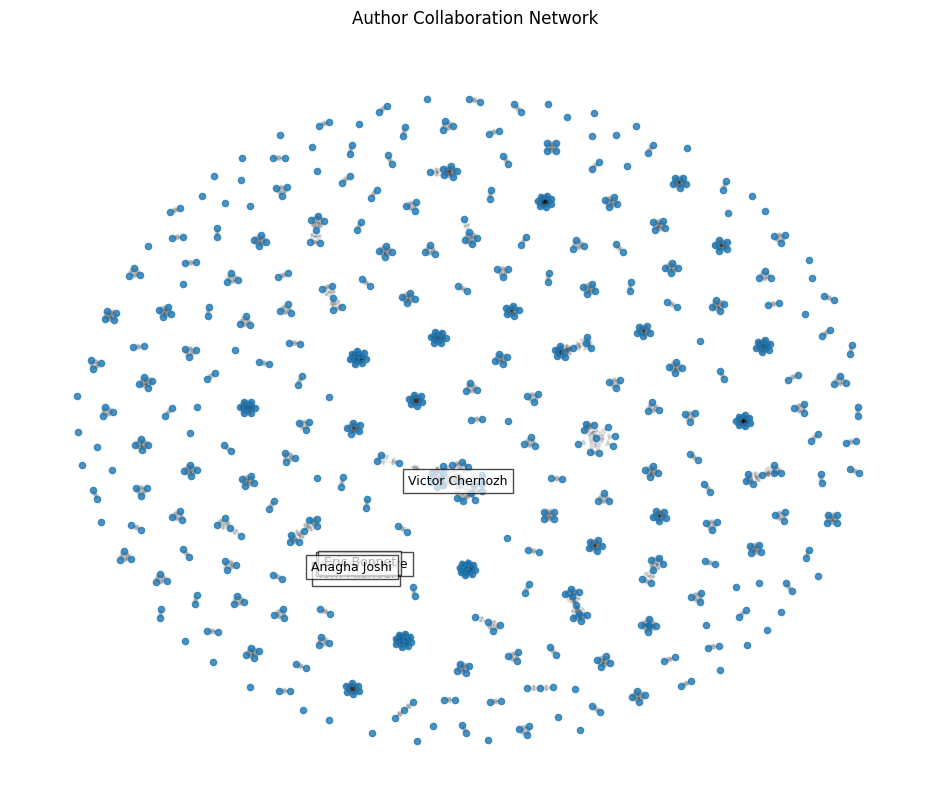

In [4]:
# Step 1.4 + Tests
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import pandas as pd

# Load the enriched graph
print("Loading graph...")
G = nx.read_graphml('enriched_graph.graphml')

# Convert embeddings from strings to numpy arrays
print("Converting embeddings...")
for node, data in G.nodes(data=True):
    if 'embedding' in data:
        data['embedding'] = np.array(
            [float(x) for x in data['embedding'].split(';')]
        )

# Initialize embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

def semantic_search(query, top_k=5):
    """Test 1.4: Semantic search functionality"""
    print(f"\n=== Semantic Search: '{query}' ===")

    # Generate query embedding
    query_embed = model.encode([query])[0]

    # Find most similar papers
    similarities = []
    for node, data in G.nodes(data=True):
        if data.get('type') == 'paper' and 'embedding' in data:
            sim = cosine_similarity([query_embed], [data['embedding']])[0][0]
            similarities.append((node, sim, data['title'], data.get('cluster')))

    # Get top results
    similarities.sort(key=lambda x: x[1], reverse=True)
    print(f"Top {top_k} results:")
    for i, (node, score, title, cluster) in enumerate(similarities[:top_k]):
        print(f"\n[{i+1}] Score: {score:.4f}, Cluster: {cluster}")
        print(f"Title: {title}")
        print(f"URL: {G.nodes[node].get('url', 'N/A')}")
        print(f"Abstract: {G.nodes[node].get('abstract', '')[:150]}...")

    return similarities[0][0]  # Return top paper node

def relationship_queries(paper_node):
    """Test 1.4: Relationship queries"""
    print("\n=== Relationship Queries ===")

    # 1. Find authors of the paper
    print(f"\nAuthors of paper: {G.nodes[paper_node]['title'][:50]}...")
    authors = [n for n in G.neighbors(paper_node)
               if G.nodes[n].get('type') == 'author']
    for author in authors[:5]:  # Show first 5 authors
        print(f"- {G.nodes[author]['name']}")

    # 2. Find collaborators of the first author
    if authors:
        author_node = authors[0]
        print(f"\nCollaborators of {G.nodes[author_node]['name']}:")
        collaborators = [n for n in G.neighbors(author_node)
                         if G.nodes[n].get('type') == 'author'
                         and G.edges[(author_node, n)].get('relationship') == 'COAUTHOR_WITH']
        for collab in collaborators[:5]:  # First 5 collaborators
            print(f"- {G.nodes[collab]['name']}")

    return author_node if authors else None

def rag_queries():
    """Test 1.4: RAG-style queries"""
    print("\n=== RAG Queries: Trending Topics ===")

    # Get all papers
    paper_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'paper']

    # Group papers by topic
    topic_counts = {}
    for paper in paper_nodes:
        topics = [n for n in G.neighbors(paper)
                 if G.nodes[n].get('type') == 'topic']
        for topic in topics:
            topic_counts[topic] = topic_counts.get(topic, 0) + 1

    # Show top 5 topics
    top_topics = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)[:5]
    print("\nTop 5 Research Topics:")
    for i, (topic_node, count) in enumerate(top_topics):
        topic_name = G.nodes[topic_node].get('category', 'Unknown')
        print(f"{i+1}. {topic_name}: {count} papers")

        # Show a representative paper in this topic
        for paper in G.neighbors(topic_node):
            if G.nodes[paper].get('type') == 'paper':
                print(f"   - {G.nodes[paper]['title'][:60]}...")
                break

def multi_hop_exploration(start_paper):
    """Test 1.4: Multi-hop exploration"""
    print("\n=== Multi-hop Exploration ===")
    print(f"Starting from paper: {G.nodes[start_paper]['title'][:50]}...")

    # Hop 1: Find similar papers (same cluster)
    cluster = G.nodes[start_paper].get('cluster')
    similar_papers = [n for n, d in G.nodes(data=True)
                     if d.get('type') == 'paper'
                     and d.get('cluster') == cluster
                     and n != start_paper]

    print(f"\nFound {len(similar_papers)} papers in the same cluster (Cluster {cluster})")

    # Hop 2: Find authors of these similar papers
    authors = set()
    for paper in similar_papers[:5]:  # First 5 similar papers
        paper_authors = [n for n in G.neighbors(paper)
                        if G.nodes[n].get('type') == 'author']
        authors.update(paper_authors)

    print(f"\nAuthors working on similar research:")
    for author in list(authors)[:5]:  # First 5 authors
        print(f"- {G.nodes[author]['name']}")

        # Hop 3: Find other papers by these authors
        author_papers = [n for n in G.neighbors(author)
                        if G.nodes[n].get('type') == 'paper'
                        and n != start_paper
                        and n not in similar_papers]

        if author_papers:
            print(f"  Other papers by this author:")
            for paper in author_papers[:2]:  # First 2 papers
                print(f"  - {G.nodes[paper]['title'][:60]}...")

def analyze_clusters():
    """Analyze paper clusters"""
    print("\n=== Paper Cluster Analysis ===")

    # Get all paper nodes with clusters
    paper_nodes = [n for n, d in G.nodes(data=True)
                  if d.get('type') == 'paper' and 'cluster' in d]

    # Create DataFrame for analysis
    cluster_data = []
    for node in paper_nodes:
        data = G.nodes[node]
        cluster_data.append({
            'cluster': data['cluster'],
            'title': data['title'],
            'year': data['year'],
            'abstract': data['abstract']
        })

    df = pd.DataFrame(cluster_data)

    # Cluster distribution
    print("\nCluster Distribution:")
    print(df['cluster'].value_counts().sort_index())

    # Show largest cluster
    largest_cluster = df['cluster'].value_counts().idxmax()
    print(f"\nLargest Cluster: {largest_cluster} ({len(df[df['cluster']==largest_cluster])} papers)")

    # Show sample titles from largest cluster
    sample_titles = df[df['cluster']==largest_cluster]['title'].sample(3).tolist()
    print("\nSample Papers:")
    for title in sample_titles:
        print(f"- {title[:70]}...")

def visualize_collaboration_network():
    """Visualize author collaboration network"""
    print("\nVisualizing collaboration network...")

    # Create author subgraph
    author_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'author']
    collaboration_edges = [(u, v) for u, v, d in G.edges(data=True)
                          if d.get('relationship') == 'COAUTHOR_WITH']

    if not author_nodes or not collaboration_edges:
        print("No collaboration data found!")
        return

    # Create subgraph
    H = G.subgraph(author_nodes)

    # Draw the graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(H, seed=42)
    nx.draw_networkx_nodes(H, pos, node_size=20, alpha=0.8)
    nx.draw_networkx_edges(H, pos, alpha=0.1)

    # Label some central authors
    degrees = dict(H.degree())
    top_authors = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]
    for author, deg in top_authors:
        plt.text(pos[author][0], pos[author][1],
                 f"{G.nodes[author]['name'][:15]}",
                 fontsize=9, ha='center', va='center',
                 bbox=dict(facecolor='white', alpha=0.7))

    plt.title("Author Collaboration Network")
    plt.axis('off')
    plt.savefig("collaboration_network.png")
    print("Saved collaboration network to collaboration_network.png")

def main():
    # Test 1: Semantic Search
    query = "quantum chromodynamics at hadron colliders"
    top_paper = semantic_search(query)

    # Test 2: Relationship Queries
    author_node = relationship_queries(top_paper)

    # Test 3: RAG Queries
    rag_queries()

    # Test 4: Multi-hop Exploration
    multi_hop_exploration(top_paper)

    # Test 5: Cluster Analysis
    analyze_clusters()

    # Test 6: Visualization
    visualize_collaboration_network()

if __name__ == "__main__":
    main()